# Plots MorbidCuriosityFMRI study
Plotting Striatum ROI:
two transverse slices for each contrast:

1. (Negative active>passive) > (Positive active>passive)
2. (Neg active>passive)

Z = -6 for Caudate and Z = 4 for Nacc/Putamen

In [1]:
import os.path as op
import numpy as np
import nibabel as nib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm_notebook
from nilearn import plotting
from nilearn import image
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.datasets import fetch_haxby
from nilearn.regions import connected_label_regions
from nilearn.datasets import load_mni152_template
%matplotlib inline

/home/lsnoek1/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/lsnoek1/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Some parameters:

In [2]:
ALPHA = 0.05 / 2  # bonferroni-corrected
THRESHOLD = 1 - ALPHA  # 1 - p-value

Gather data:

In [3]:
mappings = dict(stat1='actpas', stat2='pasact', stat3='act', stat4='pas')
data = dict()
for ctype in [d for d in glob('*') if op.isdir(d)]:
    
    data[ctype] = dict(wholebrain=dict())
    wholebrain_imgs = sorted(glob(op.join(ctype, '*.nii.gz')))
    for w_img in wholebrain_imgs:
        contrast = w_img.split('_')[-1].split('.')[0]
        data[ctype]['wholebrain'][mappings[contrast[1:]]] = w_img

    for masktype in ['IFG', 'Striatum']:
        
        data[ctype][masktype] = dict()
        p_imgs = sorted(glob(op.join(ctype, masktype + '_bin', '*.nii.gz')))
        t_imgs = sorted(glob(op.join(ctype, masktype + '_bin', '*bin_tstat*')))
        
        for p_img, t_img in zip(p_imgs, t_imgs):
            
            contrast = mappings[p_img.split('_')[-1].split('.')[0][1:]]
            
            t_data = nib.load(t_img).get_data()
            t_data[nib.load(p_img).get_data() <= THRESHOLD] = 0
            t_masked = nib.Nifti1Image(t_data, affine=nib.load(t_img).affine)
            
            data[ctype][masktype][contrast] = dict(
                p=p_img,
                t=t_img,
                t_masked=t_masked
            )

Atlases:

In [4]:
subc_atlas_prob = fetch_atlas_harvard_oxford('sub-prob-2mm', symmetric_split=False)
cort_atlas_prob = fetch_atlas_harvard_oxford('cort-prob-2mm', symmetric_split=False)
affine = load_mni152_template().affine

In [9]:
roi_info = dict(
    subc=dict(
        atlas=subc_atlas_prob,
        rois=dict(
            anat=['Left Caudate', 'Right Caudate',
                  'Left Putamen', 'Right Putamen',
                  'Left Accumbens', 'Right Accumbens'],
            func=[]
        ),
        masks=dict(
            anat=[],
            func=[]
        )
        
    ),
    cort=dict(
        atlas=cort_atlas_prob,
        rois=dict(
            anat=['Inferior Frontal Gyrus, pars triangularis',
                  'Inferior Frontal Gyrus, pars opercularis'],
            func=[]
        ),
        masks=dict(
            anat=[],
            func=[]
        )
    )
)

for atlas_name in ['subc', 'cort']:
    atlas = roi_info[atlas_name]['atlas']
    atlas_map = nib.load(atlas['maps']).get_data()
    prob_rois = (atlas_map[:, :, :, [atlas['labels'].index(roi) - 1 for roi in roi_info[atlas_name]['rois']['anat']]])
    maxp = prob_rois.argmax(axis=-1)

    for i, roi in enumerate(roi_info[atlas_name]['rois']['anat']):
        this_roi = (atlas_map[:, :, :, [atlas['labels'].index(roi) - 1]]).squeeze()
        this_roi_bin = this_roi > 0
        #roi_info[atlas_name]['masks_simple'].append(nib.Nifti1Image(this_roi_bin.astype(int), affine))
        mask = np.logical_and(this_roi_bin, ((prob_rois != 0).sum(axis=-1) > 1))
        this_roi_max = (maxp == i)
        this_roi_bin[mask] = (maxp == i)[mask]
        roi_info[atlas_name]['masks']['anat'].append(nib.Nifti1Image(this_roi_bin.astype(int), affine))
        
    roi_info[atlas_name]['rois']['func'].append('conjunction_%s' % atlas_name)
    concat = image.concat_imgs(roi_info[atlas_name]['masks']['anat']).get_data().sum(axis=-1) > 0
    roi_info[atlas_name]['masks']['func'].append(nib.Nifti1Image(concat.astype(int), affine))

for contr in ['desc_neg', 'desc_negpos']:
    for roi in ['Striatum', 'IFG']:
        atl = 'subc' if roi == 'Striatum' else 'cort'
        func_roi = '%s/%s_bin/%s_bin_tfce_corrp_tstat1.nii.gz' % (contr, roi, roi)
        mask = (nib.load(func_roi).get_data() > THRESHOLD).astype(int)
        mask = nib.Nifti1Image(mask, affine)
        roi_info[atl]['masks']['func'].append(mask)
        roi_info[atl]['rois']['func'].append('%s_%s_func' % (contr, roi))

## ROI-analysis: negative (act-pas)

/home/lsnoek1/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


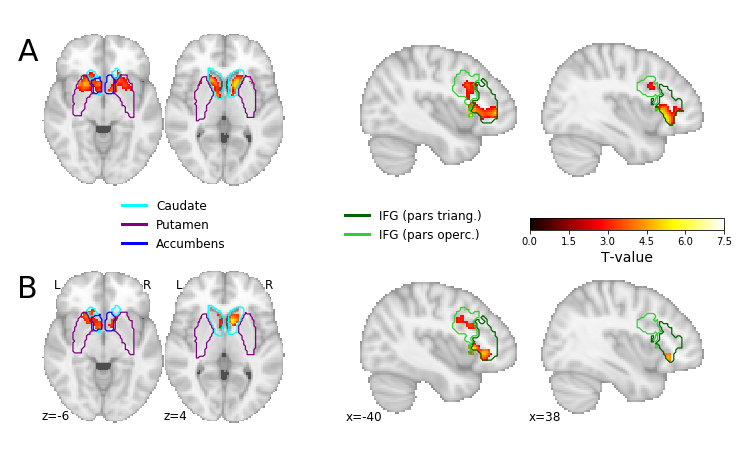

In [10]:
import matplotlib.colors as mcolors
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

gs_kw = dict(width_ratios=[1, 1.5])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), gridspec_kw=gs_kw)

imgs = [
    [
        data['desc_neg']['Striatum']['actpas']['t_masked'],
        data['desc_neg']['IFG']['actpas']['t_masked']
    ],
    
    [
        data['desc_negpos']['Striatum']['actpas']['t_masked'],
        data['desc_negpos']['IFG']['actpas']['t_masked']
    ]
]

coords = [('z', -6, 4), ('x', -40, 38)]
caudate_color = 'cyan'
putamen_color = 'purple'
accumbens_color = 'blue'
ifg_pt = 'darkgreen'
ifg_po = 'limegreen'

contour_colors = dict(
    subc=[caudate_color, caudate_color, putamen_color, putamen_color, accumbens_color, accumbens_color],
    cort=[ifg_pt, ifg_po]
)

for i in [0, 1]:
    
    for ii, atlas in [(0, 'subc'), (1, 'cort')]:
        
        display = plotting.plot_stat_map(
            stat_map_img=imgs[i][ii],
            display_mode=coords[ii][0],
            cut_coords=coords[ii][1:],
            colorbar=False,
            figure=fig,
            annotate=True if i == 1 else False,
            axes=axes[i, ii],
            vmax=7.5
        )

        if i == 0 and ii == 1:
            mappable = display.axes[-40.0].ax.images[1]
            # [left, bottom, width, height]
            cbaxes = fig.add_axes([0.69, 0.5, 0.225, 0.02]) 
            cb = plt.colorbar(mappable, orientation='horizontal', #cmap=cmap,
                              cax=cbaxes, boundaries=np.linspace(0, 7.5, 1001),
                              ticks=np.linspace(0, 7.5, 6))
            cb.set_label('T-value', fontsize=14)

        for iii, roi in enumerate(roi_info[atlas]['masks']['anat']):
            display.add_contours(
                roi,
                levels=[0.99],
                colors=contour_colors[atlas][iii],
                antialiased=True,
                linewidths=1.25
            )

axes[1, 0].legend(
    handles=[
        plt.Line2D([0], [0], color=caudate_color, lw=3),
        plt.Line2D([0], [0], color=putamen_color, lw=3),
        plt.Line2D([0], [0], color=accumbens_color, lw=3)
    ],
    labels=['Caudate', 'Putamen', 'Accumbens'],
    frameon=False,
    fontsize=12,
    bbox_to_anchor=(0.8, 1.3)
)

axes[1, 1].legend(
    handles=[
        plt.Line2D([0], [0], color=ifg_pt, lw=3),
        plt.Line2D([0], [0], color=ifg_po, lw=3)
    ],
    labels=['IFG (pars triang.)', 'IFG (pars operc.)'],
    frameon=False,
    fontsize=12,
    bbox_to_anchor=(0.4, 1.25)
)

axes[0, 0].text(-0.1, 0.75, 'A', fontsize=30)
axes[1, 0].text(-0.1, 0.75, 'B', fontsize=30)
plotting.show()
fig.savefig('../figures/figure1.png', dpi=200, bbox_inches='tight')

display.close()

## Wholebrain: negative, positive, conjunction
Plotting Whole brain one plot with three colours

X = 20 (saggital slice dACC), X = 46 (saggital slice IFG), Y = 69, Z = 36 for transverse and coronal slices)
a.	Neg active > passive 
File: FEAT, Cope1, thresh_zstat_1.nii.gz
b.	Pos active > passive 
File: FEAT, Cope2, thresh_zstat_1.nii.gz
c.	Conjunction: neg active > passive  && pos active > passive

<input>:94: DeprecationWarning: invalid escape sequence \m
<input>:94: DeprecationWarning: invalid escape sequence \m
<input>:94: DeprecationWarning: invalid escape sequence \m
<input>:94: DeprecationWarning: invalid escape sequence \m
<input>:94: DeprecationWarning: invalid escape sequence \m
<input>:94: DeprecationWarning: invalid escape sequence \m
<input>:94: DeprecationWarning: invalid escape sequence \m
<input>:94: DeprecationWarning: invalid escape sequence \m
<input>:94: DeprecationWarning: invalid escape sequence \m
<ipython-input-14-3a5db6d3a0ab>:94: DeprecationWarning: invalid escape sequence \m
  """
/home/lsnoek1/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lsnoek1/anaconda3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_lik

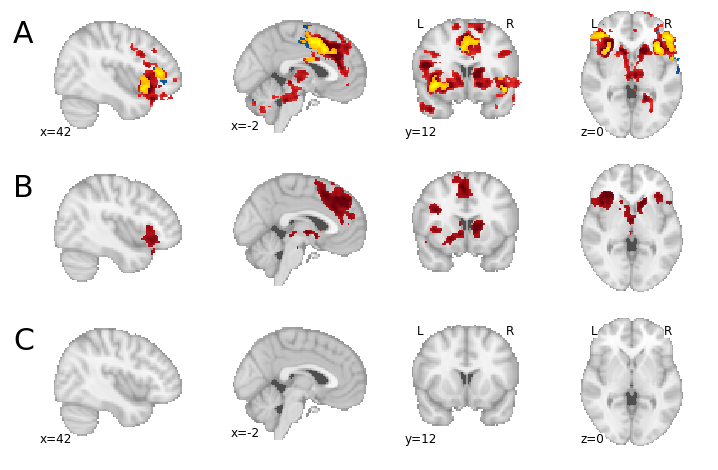

In [14]:
### Plotting the whole-brain analysis, with the conjunction. Be aware that this file should change!
wb_neg = data['desc_neg']['wholebrain']['actpas']
wb_pos = data['desc_pos']['wholebrain']['actpas']
wb_negpos = data['desc_negpos']['wholebrain']['actpas']
wb_posneg = data['desc_posneg']['wholebrain']['actpas']
wb_conj = 'thresh_conjunction_cue-negpos_contrast-actpas.nii.gz'

color_neg = plt.get_cmap('Reds')
color_pos = plt.get_cmap('Blues')
color_conj = plt.get_cmap('autumn')
color_negpos = color_neg

coords = [('x', 42), ('x', -2), ('y', 12), ('z', 0)]
gs_kw = dict(width_ratios=[1.25, 1, 1, 1])
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8), gridspec_kw=gs_kw)

for i in range(axes.shape[1]):

    display = plotting.plot_stat_map(
        stat_map_img=wb_pos,
        display_mode=coords[i][0],
        cut_coords=[coords[i][1]],
        threshold=0,
        vmax=4,
        cmap=color_pos,
        colorbar=False,
        draw_cross=False,
        figure=fig,
        axes=axes[0, i]
    )

    display.add_overlay(
        wb_neg,
        threshold=0,
        vmax=4,
        vmin=0,
        cmap=color_neg
    )

    display.add_overlay(
        wb_conj,
        threshold=0,
        vmax=4,
        vmin=0,
        cmap=color_conj
    )
    
    display = plotting.plot_stat_map(
        stat_map_img=wb_negpos,
        display_mode=coords[i][0],
        cut_coords=[coords[i][1]],
        threshold=0,
        vmax=4,
        cmap=color_negpos,
        colorbar=False,
        draw_cross=False,
        figure=fig,
        axes=axes[1, i],
        annotate=False
    )
    
    display = plotting.plot_stat_map(
        stat_map_img=wb_posneg,
        display_mode=coords[i][0],
        cut_coords=[coords[i][1]],
        threshold=0,
        vmax=3,
        cmap='purple_green_r',
        colorbar=False,
        draw_cross=False,
        figure=fig,
        axes=axes[2, i]
    )

"""
axes[0, 3].legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='purple'),
        plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='green'),
        plt.Line2D([0],ranges [0], marker='o', color='white', markerfacecolor='orange'),   
    ],
    labels=['Positive', 'Negative', 'Conjunction'],
    frameon=False,
    bbox_to_anchor=(1.7, 0.75)
)
"""
"""
axes[0, 0].text(-0.275, 0.65, 'Neg,', fontsize=20, color=color_neg(200), ha='center')
axes[0, 0].text(-0.275, 0.5, 'Pos,', fontsize=20, color=color_pos(200), ha='center')
axes[0, 0].text(-0.275, 0.35, r'$\mathrm{Neg} \cap \mathrm{Pos}$', color=color_conj(200), fontsize=20, ha='center')

axes[1, 0].text(-0.275, 0.5, 'Neg > pos', fontsize=20, color=color_negpos(200), ha='center')
axes[2, 0].text(-0.275, 0.5, 'Pos > neg', fontsize=20, ha='center')
"""

axes[0, 0].text(-.1, 0.75, 'A', fontsize=30)
axes[1, 0].text(-.1, 0.75, 'B', fontsize=30)
axes[2, 0].text(-.1, 0.75, 'C', fontsize=30)

plotting.show()
fig.savefig('../figures/figure2.png', dpi=200)
display.close()

## Directional plots

In [36]:
fl_results = dict(sub=[], valence=[], condition=[], nifti_file=[], ROI=[], beta=[])
neg_files = sorted(glob('../../data/bids/derivatives/firstlevel/sub*/reg_standard/stats/cope1.nii.gz'))
pos_files = sorted(glob('../../data/bids/derivatives/firstlevel/sub*/reg_standard/stats/cope2.nii.gz'))

for i, files in enumerate([neg_files, pos_files]):
    valence = 'Negative' if i == 0 else 'Positive'
    for ii, stat_file in tqdm_notebook(enumerate(files)):
        sub = stat_file.split('/')[-4].split('.')[0]
        condition = 'Active' if ii < 27 else 'Passive'
        
        for atlas in ['subc', 'cort']:
            for iii, roi in enumerate(roi_info[atlas]['masks']['func']):
                mask = roi.get_data() > 0
                maskname = roi_info[atlas]['rois']['func'][iii]
                img = nib.load(stat_file).get_data()
                mean_beta = img[mask].mean()

                fl_results['sub'].append(sub)
                fl_results['valence'].append(valence)
                fl_results['condition'].append(condition)
                fl_results['nifti_file'].append(stat_file)
                fl_results['ROI'].append(maskname)
                fl_results['beta'].append(mean_beta)

/home/lsnoek1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lsnoek1/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/lsnoek1/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


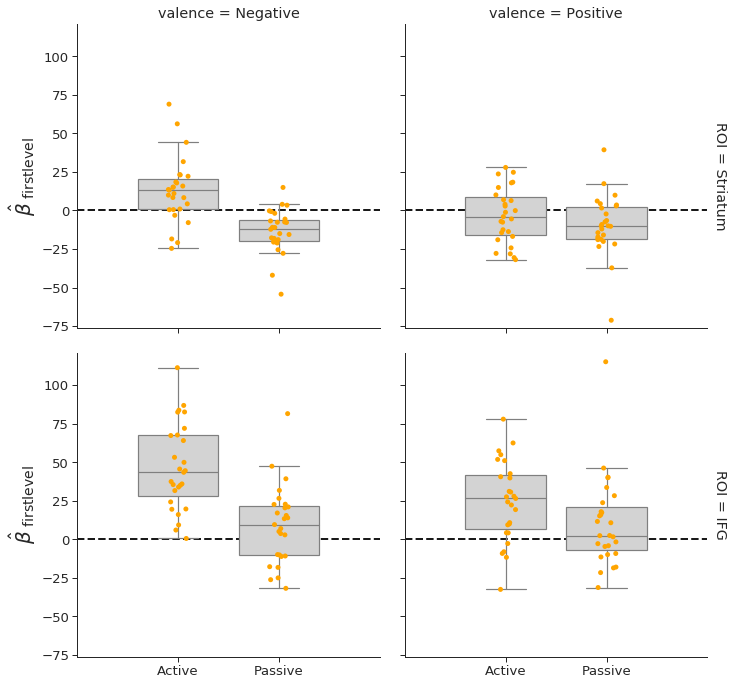

In [61]:
df = pd.DataFrame(fl_results)
dffunc = df.loc[df.ROI.str.contains('desc_negpos'), :]
dffunc['ROI'] = [s.split('_')[-2] for s in dffunc['ROI']]

bx_kwargs = dict(
    fliersize=0,
    saturation=1,
    color='lightgray'
)
sns.set(font_scale=1.5, context='paper', style='ticks')

g = sns.FacetGrid(dffunc, col='valence', row='ROI', aspect=1, height=5, margin_titles=True,)
g.map(plt.axhline, y=0, ls='--', c='k', lw=2, zorder=-1)
g.map(sns.boxplot, 'condition', 'beta', **bx_kwargs);
g.map(sns.stripplot, 'condition', 'beta', color='orange')
g.set(xlim=(-1, 2), ylim=(-76, 121), xlabel='')
g.axes[0,0].set_ylabel(r'$\hat{\beta}_{\mathrm{\ firstlevel}}$', fontsize=20)
g.axes[1,0].set_ylabel(r'$\hat{\beta}_{\mathrm{\ firstlevel}}$', fontsize=20)
plt.savefig('../figures/figure3.png', dpi=200)

/home/lsnoek1/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/lsnoek1/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


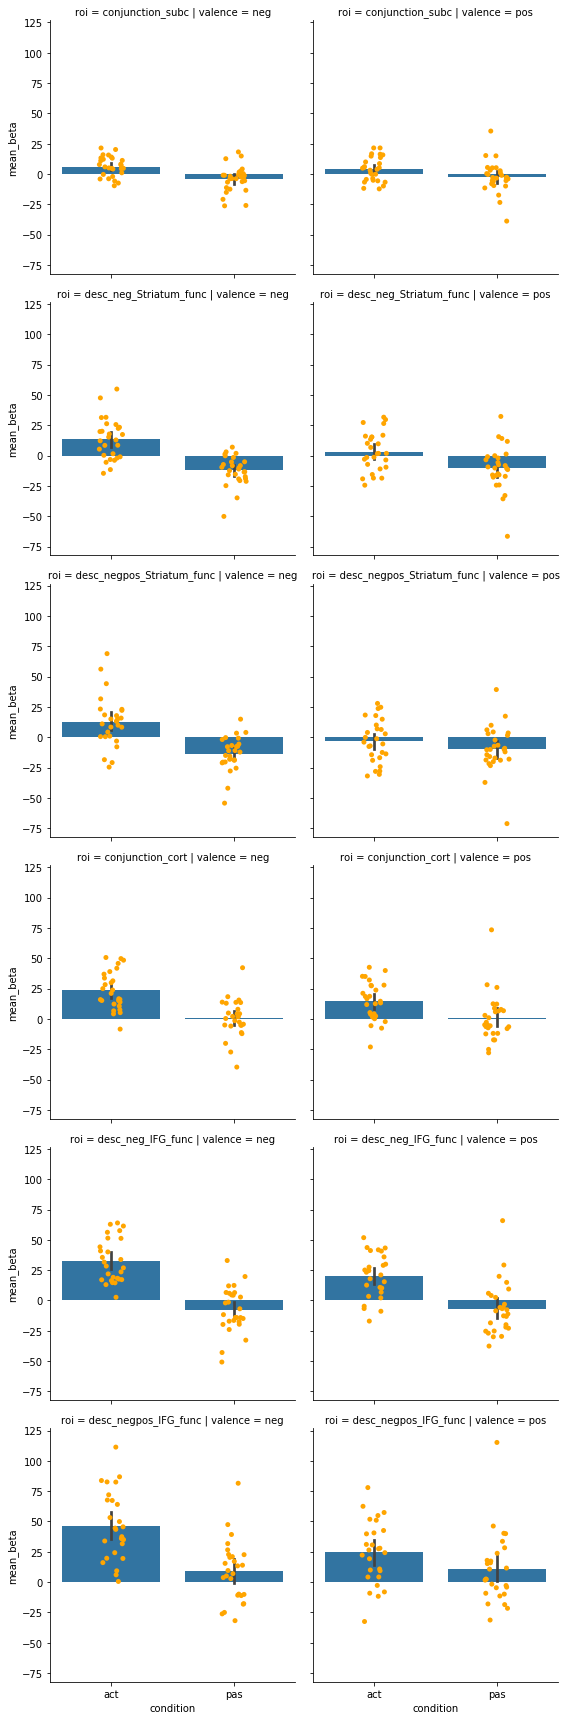

In [16]:
g = sns.FacetGrid(df, row='roi', col='valence', aspect=1, height=4)
g.map(sns.barplot, 'condition', 'mean_beta');
g.map(sns.stripplot, 'condition', 'mean_beta', color='orange');